In [19]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append("incl/")

import ELPH_utils
import ELPH_Scaler
import ELPH_Optimizer

from ELPH_ELM import SVDELM

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
runs = ELPH_utils.load_runs(filename='../runs_rand_inits.npz')

# runs = runs[::5]
# for k in range(len(runs)):
#     runs[k] = runs[k][:,::2]

n_runs = len(runs)
n_kmax = runs[0].shape[0]

print(n_runs, 'loaded with n_kmax =', n_kmax)

500 loaded with n_kmax = 80


In [11]:
optimizer = ELPH_Optimizer.ridge(alpha=10.**-3.43)

# scaler = ELPH_Scaler.standardize_scaler()
scaler = ELPH_Scaler.normalize_scaler(0.63)
# scaler = ELPH_Scaler.tanh_scaler(arg_scale=1.0, out_scale=0.3)

ELM = SVDELM(runs)
ELM.train(rdim=20, prdim = 30, n_VAR_steps=2, ELM_nodes=500, intercept=True, optimizer=optimizer, scaler=scaler)
ELM.print_status()

0.0 1.0 1000 None None 500
0.0 1.0 500
rdim:  20
n_VAR_steps:  2
ELM_nodes:  500
ELM_weights_mean:  0.0
ELM_weights_std:  1.0
VAR state shape:  (40, 199500)
ELM state shape:  (541, 199500)
target shape:  (30, 199500)
weights shape:  (541, 30)


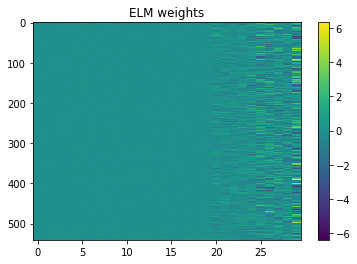

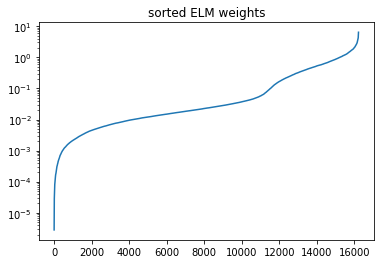

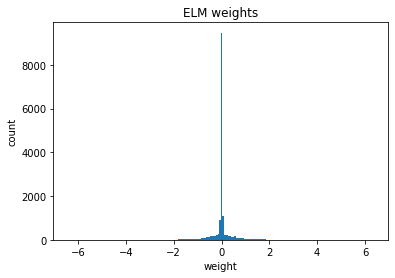

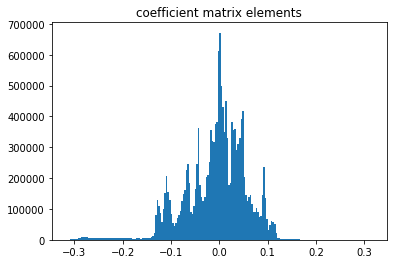

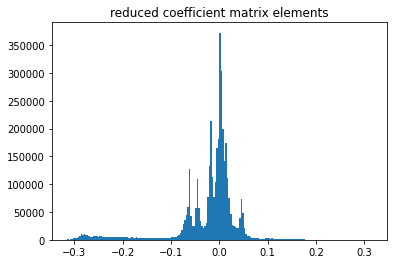

In [14]:
plt.imshow(ELM.w, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('ELM weights')
plt.show()

plt.semilogy(np.sort(np.ravel(np.abs(ELM.w))))
plt.title('sorted ELM weights')
plt.show()

plt.hist(np.ravel(ELM.w), bins=200)
plt.title('ELM weights')
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

plt.hist(np.ravel(ELM.coef_matrix), bins=200)
plt.title('coefficient matrix elements')
plt.show()

plt.hist(np.ravel(ELM.coef_matrix[:ELM.rdim]), bins=200)
plt.title('reduced coefficient matrix elements')
plt.show()

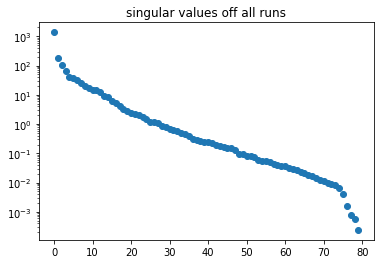

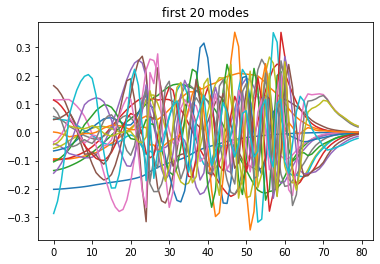

In [15]:
plt.semilogy(ELM.S, 'o')
plt.title('singular values off all runs')
plt.show()
 
for l in range(ELM.rdim):
  plt.plot(ELM.U[:,l],  label='U_'+str(l))
plt.title('first ' + str(ELM.rdim) + ' modes')
plt.show()

In [37]:
optimizer = ELPH_Optimizer.ridge(alpha=10.**-2)
scaler = ELPH_Scaler.normalize_scaler(1.0)

train_kwargs = {'rdim':20, 'prdim':30, 'n_VAR_steps':2, 'ELM_nodes':1000,  'ELM_weights_mean':0.0, 'ELM_weights_std':1.0, 'intercept':True, 'full_hist':False, 'optimizer':optimizer, 'scaler':scaler}
score_kwargs = {'norm':'max', 'errSVD':False}

m,s = ELPH_utils.get_KFold_CV_scores(ELM, runs, folds=5, seed=817, score_kwargs=score_kwargs, train_kwargs=train_kwargs)
print(m)
print(np.std(s))
print(s)

0.07602393094327604
0.10097041320953817
[0.27704927108514865, 0.01844950669850547, 0.04400173693587429, 0.01752397560779465, 0.02309516438905713]


In [31]:
def elm_error(elm_std):
    optimizer = ELPH_Optimizer.ridge(alpha=10.**-3.43)
    scaler = ELPH_Scaler.normalize_scaler(0.63)

    train_kwargs = {'rdim':20, 'prdim':30, 'n_VAR_steps':2, 'ELM_nodes':1000,  'ELM_weights_mean':0.0, 'ELM_weights_std':elm_std, 'intercept':True, 'full_hist':False, 'optimizer':optimizer, 'scaler':scaler}
    score_kwargs = {'norm':'max', 'errSVD':False}

    m,s = ELPH_utils.get_KFold_CV_scores(ELM, runs, folds=5, seed=817, score_kwargs=score_kwargs, train_kwargs=train_kwargs)
    return -np.sum(s)

from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {'elm_std': (0.01, 5)}

optimizer = BayesianOptimization(
    f=elm_error,
    pbounds=pbounds,
    random_state=1,
)


optimizer.maximize(
    init_points=10,
    n_iter=90,
)

|   iter    |  target   |  elm_std  |
-------------------------------------
|  1        | -0.9199   |  2.091    |
|  2        | -4.995    |  3.604    |
|  3        | -0.3244   |  0.01057  |
|  4        | -0.1911   |  1.519    |
|  5        | -0.0626   |  0.7423   |
|  6        | -0.0792   |  0.4708   |
|  7        | -0.07251  |  0.9394   |
|  8        | -0.5774   |  1.734    |
|  9        | -0.9377   |  1.99     |
|  10       | -2.181    |  2.699    |
|  11       | -7.212    |  5.0      |
|  12       | -0.07658  |  1.232    |
|  13       | -1.053    |  0.2595   |
|  14       | -0.631    |  1.734    |
|  15       | -0.3761   |  1.731    |
|  16       | -0.06228  |  0.746    |
|  17       | -0.06072  |  0.9353   |
|  18       | -0.1402   |  1.236    |
|  19       | -0.07524  |  0.4752   |
|  20       | -0.2339   |  1.514    |
|  21       | -0.09559  |  1.227    |
|  22       | -0.09205  |  1.222    |
|  23       | -0.07233  |  1.217    |
|  24       | -0.07295  |  1.212    |
|  25       

KeyboardInterrupt: 

In [34]:
optimizer = ELPH_Optimizer.ridge(alpha=10.**-3.43)
scaler = ELPH_Scaler.normalize_scaler(1.0)

train_kwargs = {'rdim':20, 'prdim':30, 'n_VAR_steps':2, 'ELM_nodes':1000,  'ELM_weights_mean':0.0, 'ELM_weights_std':1.0, 'intercept':True, 'full_hist':False, 'optimizer':optimizer, 'scaler':scaler}
score_kwargs = {'norm':'max', 'errSVD':False}

m,s = ELPH_utils.get_KFold_CV_scores(ELM, runs, folds=5, seed=817, score_kwargs=score_kwargs, train_kwargs=train_kwargs)
print(m)
print(np.std(s))
print(s)

0.035555279221701076
0.0165254354807637
[0.011814595872674407, 0.02040061798817875, 0.0420381388256398, 0.0502036022210863, 0.0533194412009261]


In [35]:
optimizer = ELPH_Optimizer.ridge(alpha=10.**-5)
scaler = ELPH_Scaler.normalize_scaler(1.0)

train_kwargs = {'rdim':20, 'prdim':30, 'n_VAR_steps':2, 'ELM_nodes':1000,  'ELM_weights_mean':0.0, 'ELM_weights_std':1.0, 'intercept':True, 'full_hist':False, 'optimizer':optimizer, 'scaler':scaler}
score_kwargs = {'norm':'max', 'errSVD':False}

m,s = ELPH_utils.get_KFold_CV_scores(ELM, runs, folds=5, seed=817, score_kwargs=score_kwargs, train_kwargs=train_kwargs)
print(m)
print(np.std(s))
print(s)

0.6322630525901223
0.31430198424130174
[0.33370302089649617, 0.30326153785292354, 0.582368040244036, 0.7912896479382167, 1.1506930160189393]
